# Visualizing Model Decoding
All the work done previously is assumed to be finished. From here, we work from the folder 'Models/Winners/', which is where 1 copy of a model for each dataset lives. That model is the best performing model we were able to come up with before. Here, we will look at the following:    

- Learning curve for test sessions, original and one created by model  
- Calculate choice decoding accuracy - remember scores are a lower bound as of now  
- Plot model grid  
- Calculate similarity scores between datasets  

In [1]:
#BOILERPLATE _______________________
#MODULES ______________________
print 'loading modules...',
import os
ROOT = os.environ['HOME'] + '/python/behavioral_performance/'
os.chdir(ROOT)

import time
import pickle
import numpy as np
import pandas as pd
import itertools
import operator
import matplotlib.pyplot as plt
from keras.models import load_model

from Visualize.session_plotting import plot_session_curve
from Visualize.session_animator import AnimatedSession



from behavioral_performance.tools import SequenceClass as SC
from behavioral_performance.scripts.dataset import sess2sequences, shuffle_sessions
idx = pd.IndexSlice
print 'done'


loading modules...

/Applications/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


 done


# Model Grid
Here we are evaluating the model grid in a primitive way [NOT RECOMMENDED]. The way we do this now is with multiprocessing in epsilon, this can actually take a good bit of time.

In [ ]:
grid_scores = pd.DataFrame(np.zeros([len(fileNames),len(fileNames)]),
                      index = fileNames,
                      columns = fileNames) 

for index, fileName in enumerate(fileNames):
    
    sequence_path = '/Users/pablomartin/python/' + \
                    'DATA_structures/RNN_sequences/OneHotBinaryMinimal/' + \
                    dataPrep + '/' + fileName
    seqs = pickle.load(open(sequence_path, 'rb'))       

    

    for cindex, compFileName in enumerate(fileNames):
        model_target = '/Users/pablomartin/python/Models/Winners/' + compFileName[:-2] + '.hdf5'
        model = load_model(model_target)        
        if fileName == compFileName:
            loss, acc = model.evaluate(x = seqs.X_test, y = seqs.y_test)
            grid_scores.loc[compFileName, fileName] = acc
        else:
            X = np.concatenate([seqs.X_train, seqs.X_validate, seqs.X_test])
            y = np.concatenate([seqs.y_train, seqs.y_validate, seqs.y_test])
            loss, acc = model.evaluate(x = X, y = y)
            grid_scores.loc[compFileName, fileName] = acc
            
print 'done'

In [ ]:
'''
This function will take a Keras model and a session dataframe. It will take the
session and prepare it for the model to use, and spit out an accuracy value.
'''

ROOT = '/Users/pablomartin/python/'
model_dirs = ROOT + 'Models/Winners/'
session_dirs = ROOT + 'DATA_structures/TbyT/'
seq_dirs = ROOT + 'DATA_structures/RNN_sequences/OneHotBinaryMinimal/'
seq_length_d = {1: 'Last', 30: 'Med', 200: 'Full'}
sets_dict = {'X_train' : 'y_train',
             'X_validate' : 'y_validate',
             'X_test' : 'y_test'}


def RNN_session_pred(session, model):
    noTrials = len(session)
    batch_size, seq_length, feature_dim = model.input_shape
    #checks whether model predicted choice only, not reward
    ch_red = lambda x,y: (x>1) == (y>1)
    #right now will only work with OneHotBinaryMinimal preparation
    combined = session['reward',0] + session['choice',0] * 2
    combined = combined.append(pd.Series([0,1,2,3]))
    combined = pd.get_dummies(combined)
    combined = combined.drop([0,1,2,3])

    sanity_check = 0
    exact_match, choice_match = 0,0
    info = {'choice' : [], 'prediction' : [], 'match' : []}
    x_seqs = []
    y_seqs = []
    for trial in range(1, noTrials - 1):
        if trial < seq_length:
            x = np.concatenate([np.zeros((seq_length - trial,4)),
                                combined.iloc[:trial].values], axis=0)
        else:
            x = combined.iloc[trial - 30: trial].values


        assert x.shape[0] == seq_length
        assert x.shape[1] == feature_dim
        if trial > 1:
            sanity_check += (np.argmax(x[-1]) == y)
        x_seqs.append(x)
        x = np.reshape(x, (1, seq_length, feature_dim))

        y_seqs.append(combined.iloc[trial])
        y = np.argmax(combined.iloc[trial])
        pred_x = np.argmax(model.predict(x))
        exact_match += (y == pred_x)
        choice_match += ch_red(pred_x, y)

        info['choice'].append(y)
        info['prediction'].append(pred_x)
        info['match'].append(ch_red(pred_x, y))
    x_seqs = np.asarray(x_seqs)
    y_seqs = np.asarray(y_seqs)
    values = model.evaluate(x = x_seqs, y = y_seqs, verbose = 0)

    exact_match_score = np.float(exact_match) / (noTrials - 2)
    choice_match_score = np.float(choice_match) / (noTrials - 2)
    sanity_check_score  = np.float(sanity_check) / (noTrials -3)
    evaluate_score = values[1]
    if sanity_check_score != 1:
        print 'sanity check failed: %.2f - should be 1.00' %(sanity_check_score)
    return [exact_match_score, choice_match_score, info, evaluate_score]



In [ ]:

for datasetIndex, fileName in enumerate(fileNames):
    print '*' * 80
    print 'working on dataset: %s' %(fileName)
    df = pickle.load(open(session_dirs + fileName, 'rb'))
    sessions = df.groupby(axis = 0, level = 'session')

    print 'loading model ...',
    model = load_model(model_dirs + fileName[:-2] + '.hdf5')
    print 'done'

    print 'loading sequences ...',
    dataPrep = seq_length_d[model.input_shape[1]] + '/'
    seqs = pickle.load(open(seq_dirs + dataPrep + fileName, 'rb'))
    print 'done'

    #determining what session belongs to what group
    print 'determining what set each session belonged to ...',
    TRAIN, VALIDATE, TEST = seqs.train_validate_test_split_by_session(df)
    TRAIN_SESSIONS = \
            [w for w, s in TRAIN.groupby(axis = 0, level = 'session')]
    VALIDATE_SESSIONS = \
            [w for w, s in VALIDATE.groupby(axis = 0, level = 'session')]
    TEST_SESSIONS = \
            [w for w, s in TEST.groupby(axis = 0, level = 'session')]
    print 'done'




    print("X_train: {}, {}".format(seqs.X_train.dtype, seqs.X_train.shape))
    print("y_train: {}, {}".format(seqs.y_train.dtype, seqs.y_train.shape))


    print 'Sequence scores using model.evaluate ...',
    results_train = \
        model.evaluate(x = seqs.X_train, y = seqs.y_train, verbose = 0)
    print 'training score : %.2f' %(results_train[1])

    print 'Sequence scores using model.predict ...',
    preds = np.argmax(model.predict(seqs.X_train), axis = 1)
    actual = np.argmax(seqs.y_train, axis=1)
    manual_score = np.float(np.sum(preds == actual)) / len(seqs.X_train)
    print 'training score : %.2f' %(manual_score)

    print 'changing dtype of y_train'
    seqs.y_train = seqs.y_train.astype(np.float64)
    print("X_train: {}, {}".format(seqs.X_train.dtype, seqs.X_train.shape))
    print("y_train: {}, {}".format(seqs.y_train.dtype, seqs.y_train.shape))


    print 'Sequence scores using model.evaluate ...',
    results_train = \
        model.evaluate(x = seqs.X_train, y = seqs.y_train, verbose = 0)

    print 'training score : %.2f' %(results_train[1])
    print model.metrics_names
    print 'Sequence scores using model.predict ...',
    preds = np.argmax(model.predict(seqs.X_train), axis = 1)
    actual = np.argmax(seqs.y_train, axis=1)
    manual_score = np.float(np.sum(preds == actual)) / len(seqs.X_train)
    print 'training score : %.2f' %(manual_score)


    match_by_hand = {}

    for setIndex, set in enumerate(sets_dict.keys()):
        tmp_match_by_hand = 0
        for t in xrange(len(seqs.__dict__[set])):
            pred = np.argmax(model.predict(
                    np.reshape(seqs.__dict__[set][t], (1,model.input_shape[1],4))))
            y_actual = np.argmax(seqs.__dict__[sets_dict[set]][t])
            tmp_match_by_hand += (pred == y_actual)
        match_by_hand[set] = \
                np.float(tmp_match_by_hand) / len(seqs.__dict__[set])



    results_validate = \
        model.evaluate(x = seqs.X_validate, y = seqs.y_validate, verbose = 0)
    results_test = \
        model.evaluate(x = seqs.X_test, y = seqs.y_test, verbose = 0)
    print 'done'

    print 'evaluating score session by session ...',
    session_dict = {}
    for label, session in sessions:
        [exact_match_score, choice_match_score, info, evaluate_score] = \
                                            RNN_session_pred(session, model)

        try:
            tmp = TRAIN_SESSIONS.index(label)
            membership = 'train'
        except ValueError:
            pass
        try:
            tmp = VALIDATE_SESSIONS.index(label)
            membership = 'validate'
        except ValueError:
            pass
        try:
            tmp = TEST_SESSIONS.index(label)
            membership = 'test'
        except ValueError:
            pass


        session_dict[label] = \
        (exact_match_score, evaluate_score, membership, choice_match_score)
    print 'done'


    print '\n'
    print 'training score : %.2f' %(results_train[1])
    print 'validation score : %.2f' %(results_validate[1])
    print 'testing score : %.2f' %(results_test[1])
    print 'scores by hand: %s' %(match_by_hand)
    print '\n'
    for sess_label in session_dict.keys():
        print 'score for session %s : %.2f - from %s - evaluate: %.2f, choice: %.2f'\
                                            %(sess_label,
                                            session_dict[sess_label][0],
                                            session_dict[sess_label][2],
                                            session_dict[sess_label][1],
                                            session_dict[sess_label][3])
    print '\n'
    print '*' * 80


In [9]:
def model_predict_session(session, model):
    X,y = sess2sequences(session, 30)
    preds = np.argmax(model.predict(X), axis=1)
    preds = np.concatenate([[np.NaN], preds[:-1]])
    preds = pd.DataFrame(preds, index = session.index, columns=['Choice'])
    preds['GA'] = session['GA']
    return preds

DSR = pickle.load(open(ROOT + 'DATA_structures/session_dataframes/DSR_SESSIONS_DATAFRAME.p','rb'))
PSR = pickle.load(open(ROOT + 'DATA_structures/session_dataframes/PSR_SESSIONS_DATAFRAME.p','rb'))
DSR_Saline = DSR.loc[idx['24','PL-saline',:,:],:]
PSR_Saline = PSR.loc[idx['57','PL-saline',:,:],:]

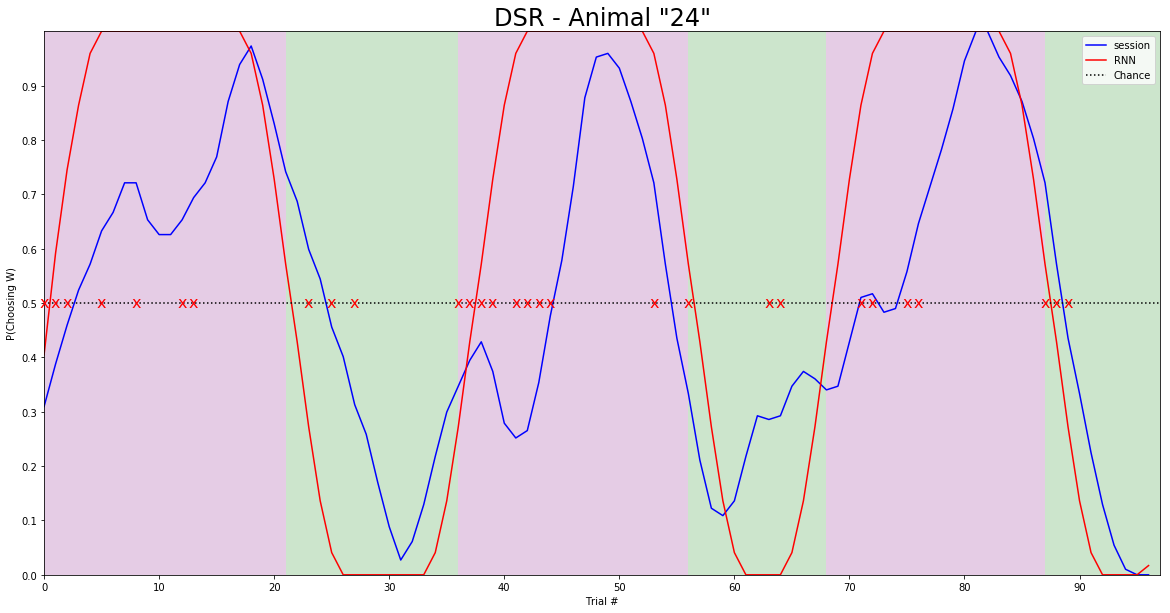

In [5]:
#DSR Saline Session
model = load_model(ROOT + 'Models/Winners/Saline_DSR.hdf5')
preds = model_predict_session(DSR_Saline, model)
plot_session_curve(session=DSR_Saline, RNN = preds, title = 'DSR - Animal "24"',savefig=1, DPI=400)

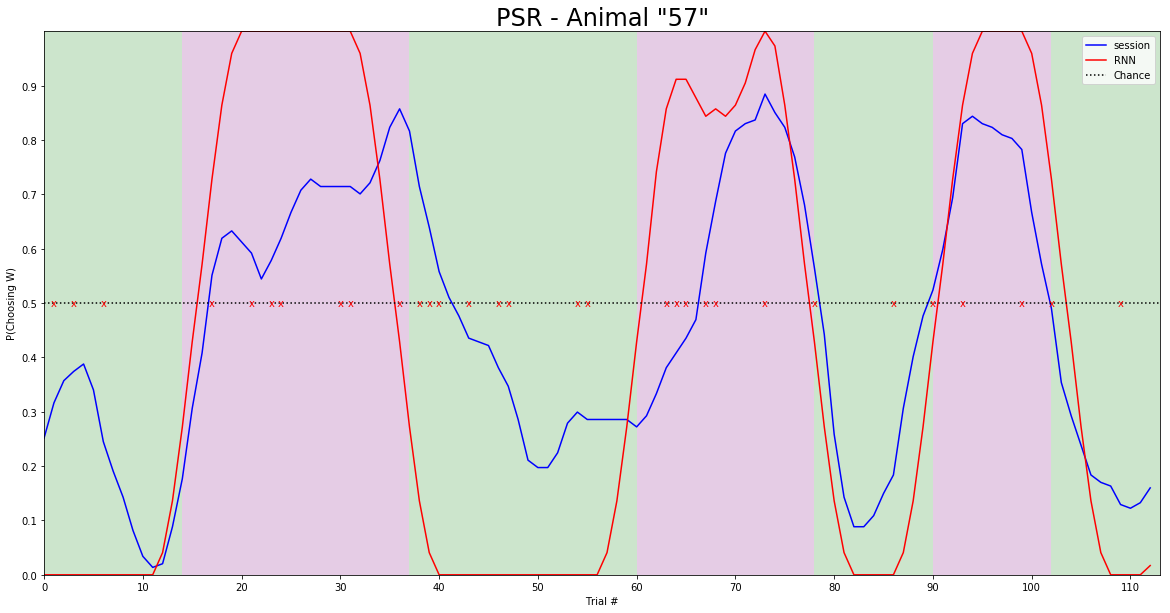

In [15]:
#PSR Saline Session
model = load_model(ROOT + 'Models/Winners/Saline_PSR.hdf5')
preds = model_predict_session(PSR_Saline, model)
plot_session_curve(session=PSR_Saline, RNN = preds, title = 'PSR - Animal "57"')

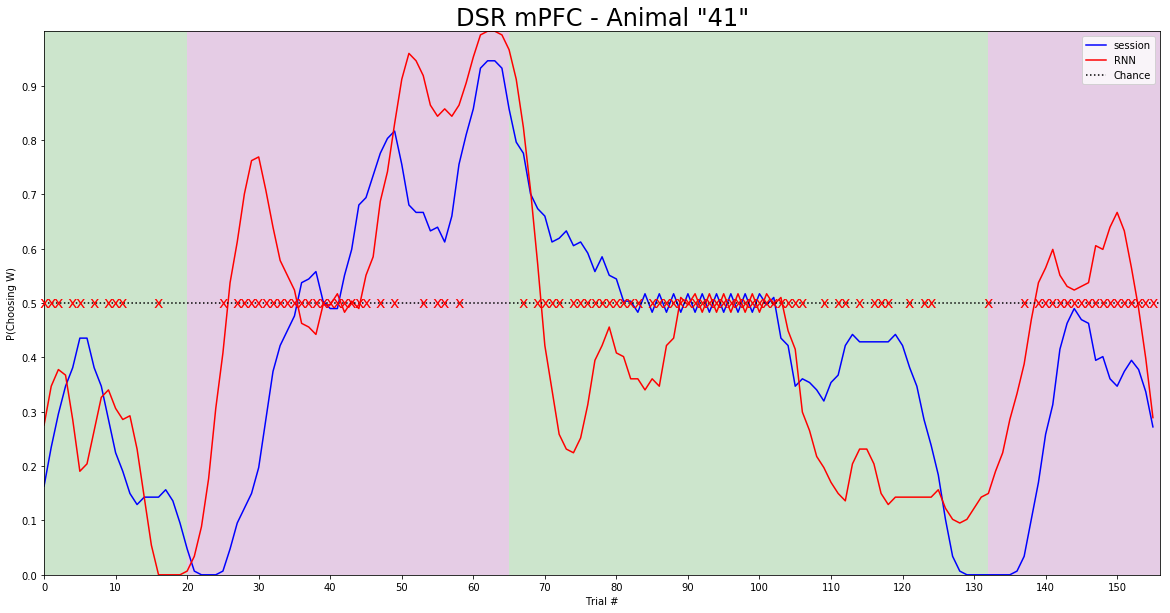

In [8]:
#DSR mPFC Session

DSR_mPFC = DSR.loc[idx['41','PL-muscimol',:,:],:]
model = load_model(ROOT + 'Models/Winners/mPFC_DSR.hdf5')
preds = model_predict_session(DSR_mPFC, model)
plot_session_curve(session=DSR_mPFC, RNN = preds, title = 'DSR mPFC - Animal "41"',savefig=1, DPI=400)

# Comparing Model Dynamics
November 29, 2018
We are generating 4 plots for my thesis. What I want is to compare the network dynamics of 3 models per session, that are handpicked. I am using data shuffle '100' of the large cross-validation simulation that I did a few weeks ago. I have all the model winners saved, and just need to determine which sessions went into the testing set to get my representative sessions. Let's do this.

In [12]:
ROOT = os.environ['HOME'] + '/python/behavioral_performance/'
dataset_dir = ROOT + 'data/dataset_dataframes/'
model_winners = ROOT + 'model_winners/'

import pandas as pd
from Visualize.session_plotting import plot_session_curve
from behavioral_performance.scripts.dataset import sess2sequences, shuffle_sessions

def get_test_session_labels(dataset):
    train_df, test_df, validate_df = \
            shuffle_sessions(dataset, 0.5, 0.25, 0.25, 100)
    return [label for label, data in test_df.groupby('SessionID')]

def model_predict_session(session, model):
    X,y = sess2sequences(session, 30)
    preds = np.argmax(model.predict(X), axis=1)
    preds = np.concatenate([[np.NaN], preds])
    preds = pd.DataFrame(preds, index = session.index, columns=['Choice'])
    preds['GA'] = session['GA']
    return preds

## Saline DSR Session
We will pick one of the test set saline DSR sessions, and plot it against the model predictions of  
a) Saline DSR  
b) OFC DSR  
c) mPFC DSR  

In [23]:
DSR_Saline_DF = pickle.load(open(dataset_dir + 'Saline_DSR.p', 'rb'))
test_sessions = get_test_session_labels(DSR_Saline_DF)

#choose one session at random
import random
idx = pd.IndexSlice
test_session = random.choice(test_sessions)
print 'We picked the session: %s' %test_session
session = DSR_Saline_DF.loc[idx[test_session.split('_')[0],test_session.split('_')[1], :,:],:]

#load our 3 models
model_salineDSR = load_model(model_winners + 'Saline_DSR.hdf5')
model_OFCDSR = load_model(model_winners + 'OFC_DSR.hdf5')
model_mPFCDSR = load_model(model_winners + 'mPFC_DSR.hdf5')

#make our artificial sessions
SalDSR_Session = model_predict_session(session, model_salineDSR)
OFCDSR_Session = model_predict_session(session, model_OFCDSR)
mPFCDSR_Session = model_predict_session(session, model_mPFCDSR)

We picked the session: 46_CONTRA-saline


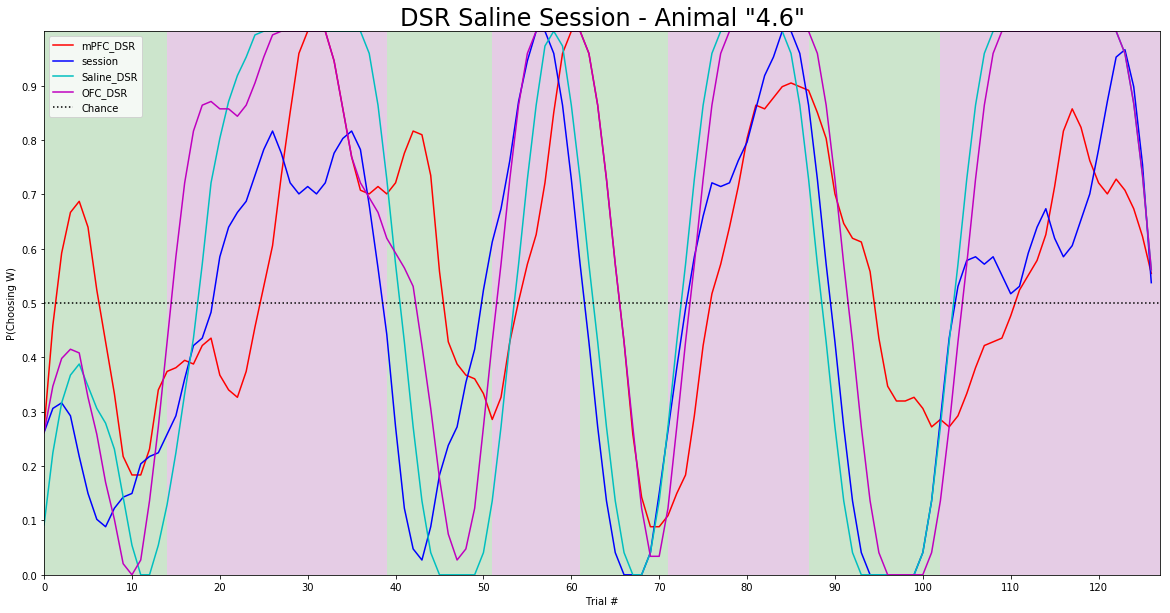

In [24]:
plot_session_curve(session=session,
                   plotErrors = 0,
                   savefig = 1,
                   title = 'DSR Saline Session - Animal "4.6"',
                   Saline_DSR = SalDSR_Session,
                   OFC_DSR = OFCDSR_Session,
                   mPFC_DSR = mPFCDSR_Session)

## Saline PSR Session
Now we will do the same for a PSR session with the following model predictions:
a)Saline PSR  
b)Saline DSR  
c)Naive PSR  

In [26]:
PSR_Saline_DF = pickle.load(open(dataset_dir + 'Saline_PSR.p', 'rb'))
test_session = random.choice(get_test_session_labels(PSR_Saline_DF))
print 'We picked the session: %s' %test_session
session = PSR_Saline_DF.loc[idx[test_session.split('_')[0],test_session.split('_')[1], :,:],:]

#load our 3 models
model_salinePSR = load_model(model_winners + 'Saline_PSR.hdf5')
model_NaiveDSR = load_model(model_winners + 'Naive_DSR.hdf5')

#make our artificial sessions
SalDSR_Session = model_predict_session(session, model_salineDSR)
SalPSR_Session = model_predict_session(session, model_salinePSR)
NaiveDSR_Session = model_predict_session(session, model_NaiveDSR)

We picked the session: 57_IPSI-saline


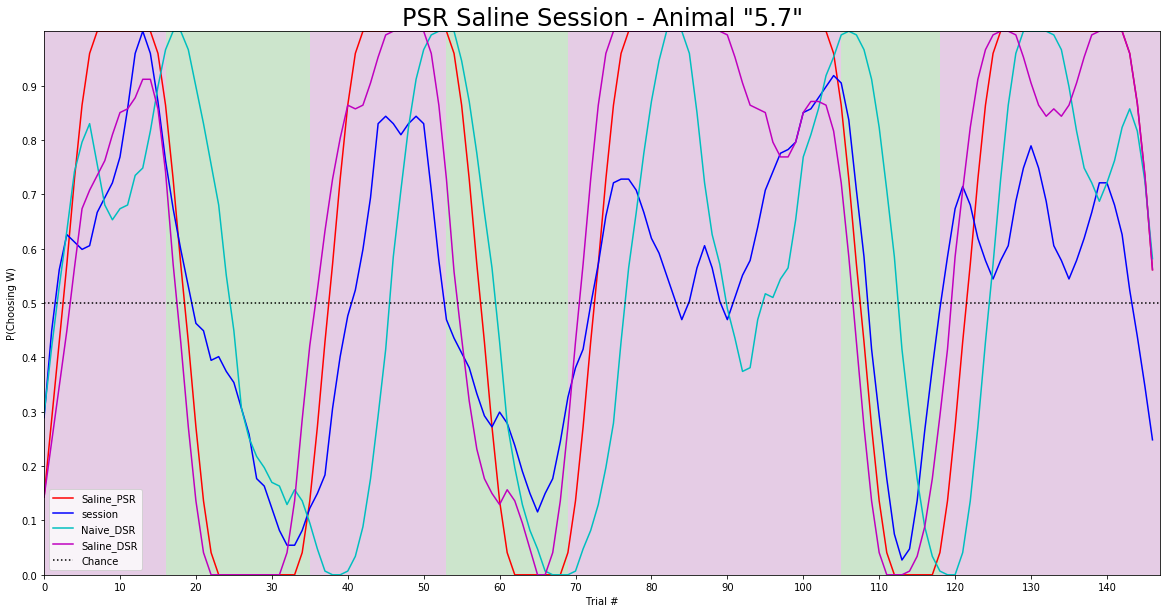

In [28]:
plot_session_curve(session=session,
                   plotErrors = 0,
                   savefig = 1,
                   title = 'PSR Saline Session - Animal "5.7"',
                   Saline_DSR = SalDSR_Session,
                   Saline_PSR = SalPSR_Session,
                   Naive_DSR = NaiveDSR_Session)

## Naive DSR Session
Same deal. Comparing the following 3 models predictions:  
a) Naive DSR  
b) mPFC DSR  
c) Saline DSR  

In [33]:
DSR_Naive_DF = pickle.load(open(dataset_dir + 'Naive_DSR.p', 'rb'))
test_session = random.choice(get_test_session_labels(DSR_Naive_DF))
print 'We picked the session: %s' %test_session
session = DSR_Naive_DF.loc[idx[test_session.split('_')[0],int(test_session.split('_')[1]), :,:],:]

#make our artificial sessions
mPFCDSR_Session = model_predict_session(session, model_mPFCDSR)
NaiveDSR_Session = model_predict_session(session, model_NaiveDSR)
SalineDSR_Session = model_predict_session(session, model_salineDSR)

We picked the session: 46_1


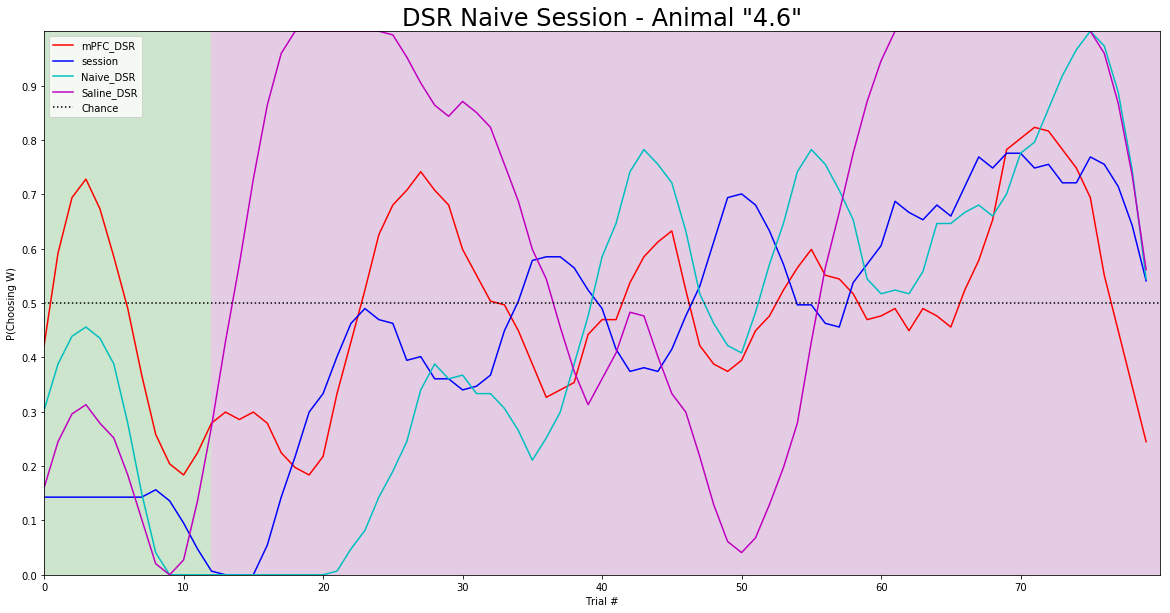

In [35]:
plot_session_curve(session=session,
                   plotErrors = 0,
                   savefig = 1,
                   title = 'DSR Naive Session - Animal "4.6"',
                   Saline_DSR = SalineDSR_Session,
                   mPFC_DSR = mPFCDSR_Session,
                   Naive_DSR = NaiveDSR_Session)

## mPFC DSR Session
OK and finally comparing mPFC DSR session with the following model predds:  
a) mPFC DSR  
b) Naive DSR  
c) Saline DSR  

In [37]:
DSR_mPFC_DF = pickle.load(open(dataset_dir + 'mPFC_DSR.p', 'rb'))
test_session = random.choice(get_test_session_labels(DSR_mPFC_DF))
print 'We picked the session: %s' %test_session
session = DSR_mPFC_DF.loc[idx[test_session.split('_')[0],test_session.split('_')[1], :,:],:]

#make our artificial sessions
mPFCDSR_Session = model_predict_session(session, model_mPFCDSR)
NaiveDSR_Session = model_predict_session(session, model_NaiveDSR)
SalineDSR_Session = model_predict_session(session, model_salineDSR)

We picked the session: 23_PL-muscimol


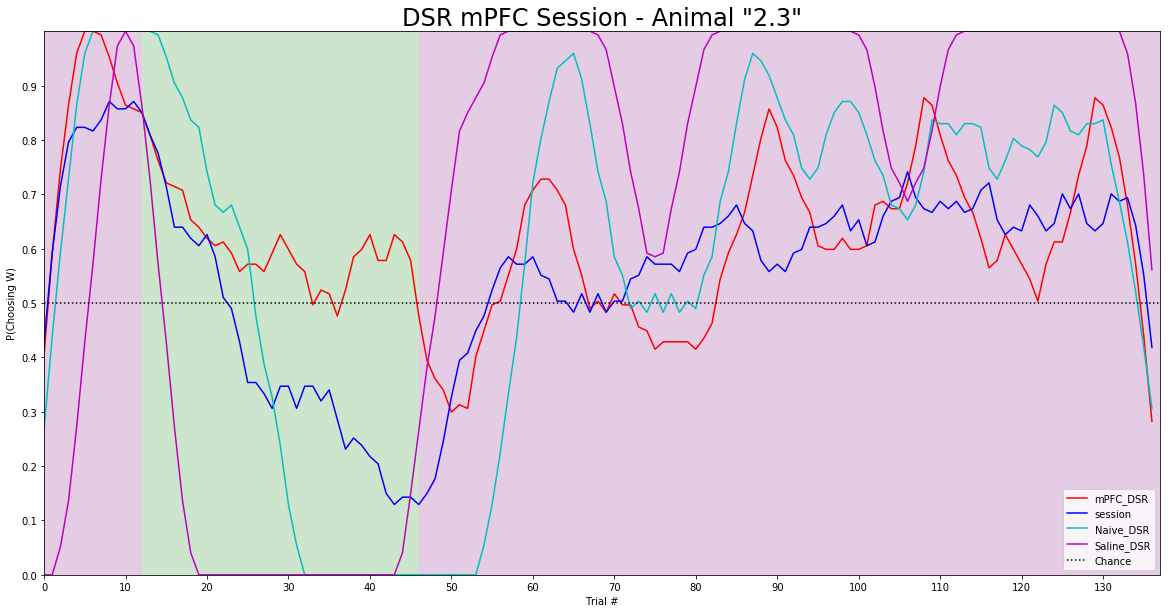

In [38]:
plot_session_curve(session=session,
                   plotErrors = 0,
                   savefig = 1,
                   title = 'DSR mPFC Session - Animal "2.3"',
                   Saline_DSR = SalineDSR_Session,
                   mPFC_DSR = mPFCDSR_Session,
                   Naive_DSR = NaiveDSR_Session)